**01_knn_baseline.ipynb**
- Goal: Very simple KNN baseline on the fraud dataset
- Load CSV
- Pick a small set of numeric features (no scaling/encoding yet)
- Train/test split
- Fit KNN
- Check basic metrics

In [1]:
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


from pathlib import Path
import sys
# Point to the project root (adjust parents[1] to parents[2] if notebook is deeper)
PROJECT_ROOT = Path.cwd().resolve().parent
sys.path.insert(0, str(PROJECT_ROOT))

# <-- Imports custom preprocessing functions from 'functions.py' <-- #

# from lib.functions import ()

# from sklearn.datasets import fetch_california_housing
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.model_selection import train_test_split
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.preprocessing import MinMaxScaler, StandardScaler

# #for preprocessing
# from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder,LabelEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# #models
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB

# <-- Loads YAML configuration to dynamically reference CSV output files. <-- #

config = None  # <-- Initialize config
try:
    with open("../config.yaml", "r") as file:
        config = yaml.safe_load(file)
except:
    print("Yaml configuration file not found!")

In [2]:
# 1) Load the dataset
df_fraud_dataset = pd.read_csv(config['output_data']['file1']) 

# data_path = "/mnt/data/synthetic_fraud_dataset.csv"
# df = pd.read_csv(data_path)

In [3]:
# 2) Inspect the data quickly
print("Shape:", df_fraud_dataset.shape)
print("Columns:", df_fraud_dataset.columns.tolist())
print(df_fraud_dataset.head(3))

Shape: (50000, 3)
Columns: ['Failed_Transaction_Count_7d', 'Risk_Score', 'Fraud_Label']
   Failed_Transaction_Count_7d  Risk_Score  Fraud_Label
0                            3      0.8494            0
1                            4      0.0959            1
2                            4      0.8400            1


In [4]:
# 3) Target and feature selection
#    For a simple baseline, we'll use numeric columns that look meaningful.
#    (IDs and text-like columns are avoided for now)
target_col = "Fraud_Label"

In [5]:
# Safety check
assert target_col in df_fraud_dataset.columns, "Target column Fraud_Label not found."

In [6]:
# Pick some numeric columns commonly useful for a baseline
# candidate_numeric = [
#     "Transaction_Amount", "Account_Balance", "IP_Address_Flag",
#     "Previous_Fraudulent_Activity", "Daily_Transaction_Count",
#     "Avg_Transaction_Amount_7d", "Failed_Transaction_Count_7d",
#     "Card_Age", "Transaction_Distance", "Risk_Score", "Is_Weekend"
# ]

candidate_numeric = [
    'Failed_Transaction_Count_7d','Risk_Score'
]

numeric_cols = [c for c in candidate_numeric if c in df_fraud_dataset.columns]

In [7]:
# Drop rows where target is missing (shouldn't happen, but just in case)
df = df_fraud_dataset.dropna(subset=[target_col]).copy()

In [8]:
# 4) Build X and y for modeling
X = df[numeric_cols].copy()
y = df[target_col].astype(int).copy()

In [9]:
# 5) Fill missing numeric values with the column median (simple and common)
for col in numeric_cols:
    if X[col].isna().any():
        X[col] = X[col].fillna(X[col].median())

In [10]:
# 6) Train/Test split (stratify to keep same fraud ratio in both sets)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Fraud rate train:", y_train.mean(), "- Fraud rate test:", y_test.mean())

Train size: (40000, 2) Test size: (10000, 2)
Fraud rate train: 0.32135 - Fraud rate test: 0.3213


In [11]:
# 7) Create and fit a simple KNN model
#    n_neighbors is a main hyperparameter; we'll start with k=15
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)

,n_neighbors,15
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [12]:
# 8) Predictions
y_pred = knn.predict(X_test)

In [13]:
# 9) Basic evaluation
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", round(acc, 4))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9998

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6787
           1       1.00      1.00      1.00      3213

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

Confusion matrix:
 [[6787    0]
 [   2 3211]]


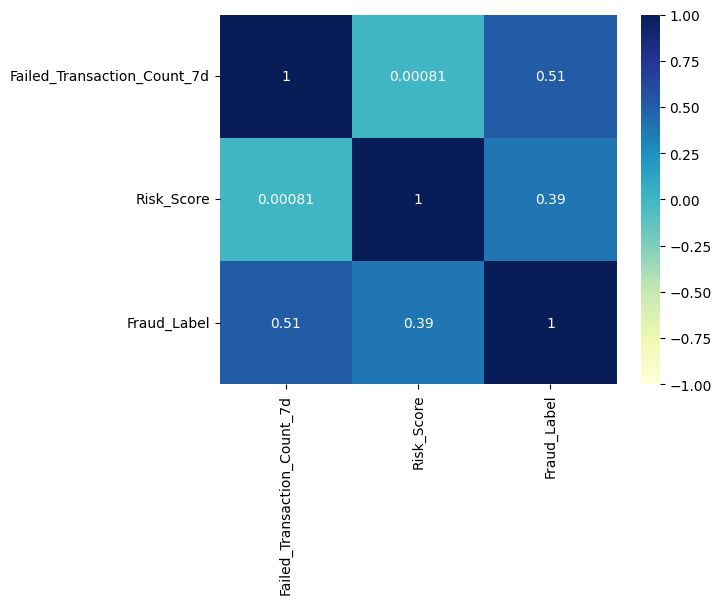

In [18]:
figsize=(15, 4)
             
corr_v = df_fraud_dataset.corr()
sns.heatmap(corr_v, annot=True, vmin=-1, vmax=1, cmap="YlGnBu")
set_title = ("Variation — Correlation matrix")